This is on Salmon v0.2.3. There is no processing in this version; queries are selected randomly. In each of these examples, one client submitted 50 responses. All clients submitted responses at the same time.

In [1]:
import pandas as pd

In [2]:
# df = pd.read_json("data/load-test-v0.2.3.json")
# df.to_json("data/load-test-v0.2.3.json.zip", compression="zip")

In [3]:
df = pd.read_json("data/load-test-v0.2.3.json.zip")

In [4]:
df.head()

,head,left,right,winner,puid,response_time,network_latency,time_received,left_object,right_object,head_object,winner_object,left_filename,right_filename,head_filename,winner_filename,time_received_since_start,datetime_received
0,15,9,28,28,11,0.359152,0.214781,1.586895e+09,10,29,16,29,10,29,16,29,55.278149,2020-04-14T20:12:29.537846
1,19,7,2,2,0,0.427487,0.218597,1.586895e+09,8,2,20,2,8,2,20,2,55.332323,2020-04-14T20:12:29.592020
2,8,21,4,4,2,0.570763,0.203890,1.586895e+09,22,5,9,5,22,5,9,5,55.460378,2020-04-14T20:12:29.720075
3,21,28,27,28,3,0.570153,0.226172,1.586895e+09,29,28,22,29,29,28,22,29,55.493153,2020-04-14T20:12:29.752850
4,23,15,20,20,6,0.690759,0.215913,1.586895e+09,16,21,24,21,16,21,24,21,55.605684,2020-04-14T20:12:29.865381


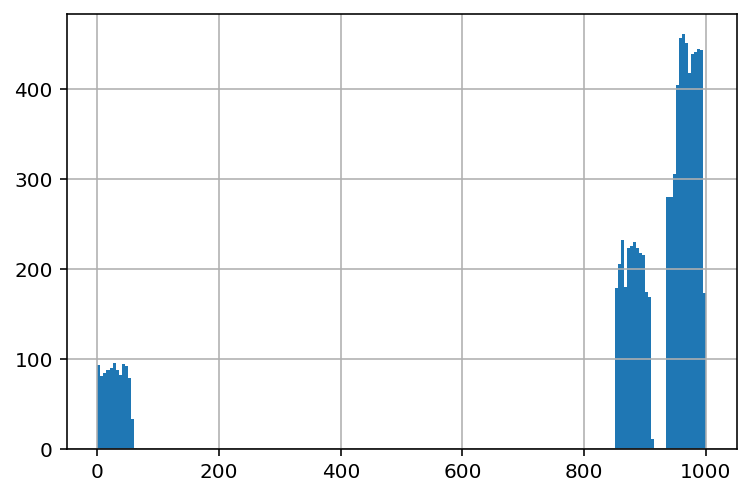

In [5]:
df["time_received"] -= df["time_received"].min()
exp1 = df[df.time_received < 200].copy()
exp2 = df[(df.time_received >= 200) & (df.time_received < 920)].copy()
exp3 = df[(df.time_received >= 920)].copy()
exps = [exp1, exp2, exp3]

ax = df.time_received.hist(bins=200)

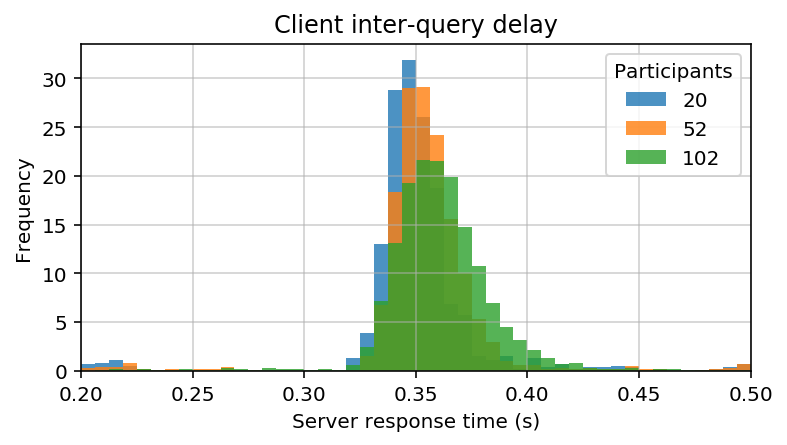

In [6]:
import matplotlib.pyplot as plt
w = 2
fig, ax = plt.subplots(figsize=(3 * w, 1.5 * w))
for k, exp in enumerate(exps):
    n_puid = exp.puid.nunique()
    _ = ax.hist(exp.network_latency, alpha=0.8, bins=2 * 80, range=(0, 1), stacked=True, density=True, label=n_puid)
_ = ax.set_xlim(0.2, 0.5)
_ = ax.grid(alpha=0.6)
_ = ax.set_xlabel("Server response time (s)")
_ = ax.legend(loc="best", title="Participants");
_ = ax.set_ylabel("Frequency")
_ = ax.set_title("Client inter-query delay")
fig.savefig("../docs/imgs/delay-histogram.svg", bbox_inches="tight")

In [7]:
import numpy as np

In [8]:
def _get_stats(x):
    data = []
    for p in [50, 90, 95, 96, 97, 98, 99]:
        datum = {"percentile": f"{p}%", "time (s)": np.percentile(x, p)}
        data.append(datum)
    return data
    
summary = [
    [{"num_clients": exp.puid.nunique(), **d} for d in _get_stats(exp.network_latency)]
    for exp in exps
]

In [9]:
import seaborn as sns
df = pd.DataFrame(sum(summary, []))
df.head()

,num_clients,percentile,time (s)
0,20,50%,0.349768
1,20,90%,0.415390
2,20,95%,0.677463
3,20,96%,0.690406
4,20,97%,0.716188


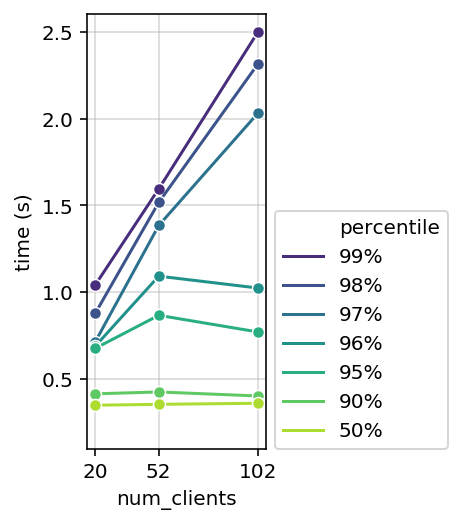

In [10]:
import matplotlib.pyplot as plt
w = 4
fig, ax = plt.subplots(figsize=(0.4 * w, w))
ax = sns.lineplot(
    data=df,
    x="num_clients",
    y="time (s)",
    hue="percentile",
    palette="viridis",
    hue_order=list(reversed(list(df.percentile.unique()))),
    marker="o",
)
ax.grid(alpha=0.5)
ax.set_ylim(100e-3, None)
ax.xaxis.set_major_locator(plt.FixedLocator(df.num_clients.unique()))
ax.legend(loc=(1.05, 0))
fig.savefig("../docs/imgs/delay-percentils.svg", bbox_inches="tight")